In [2]:
import sys
from pathlib import Path

project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

import src.seed as seed
import src.models as models
import src.functions as fn

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import time

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
# needs kaleido to work 
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+png"

In [3]:
device = seed.device
generator = seed.generator

X, y, X_test, y_test = fn.load_cifar_10()

Files already downloaded and verified
Files already downloaded and verified


C:\Users\Eric\DSC Capstone\Investigating-NN-Optimizers\src\functions.py:82: UserWarning:

expandable_segments not supported on this platform (Triggered internally at C:\cb\pytorch_1000000000000\work\c10/cuda/CUDAAllocatorConfig.h:28.)



In [4]:
from torch.utils.data import TensorDataset, DataLoader

In [5]:
# Model Parameters
input_size = X.shape[1] * X.shape[2] * X.shape[3]
num_hidden_layers = 2
hidden_layer_size = 200

output_dir = "eos/sgd_EC"
num_labels = 10

In [6]:
# Dataloader for SGD
batch_size = 128

train_dataset = TensorDataset(X, y)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=seed.cpu_generator
)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Single Model Tests

In [6]:
# Training Parameters
epochs = 2000
learning_rate = 0.05
accuracy = 0.999

model = models.FullyConnectedNet(
    input_size=input_size,
    num_hidden_layers=num_hidden_layers,
    hidden_layer_size=hidden_layer_size,
    num_labels=10,
    activation=nn.Tanh
)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.0)

# Train with mini-batch SGD, compute Hessian on full batch
fn.train_sgd_model(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    epochs=epochs,
    accuracy=accuracy,
    train_loader=train_loader,
    test_loader=test_loader,
    X=X,
    y=y,
    output_dir=output_dir
)

Training FullyConnectedNet with SGD and learning rate 0.05 for 2000 epochs.
Completed training of FullyConnectedNet with SGD and learning rate 0.05. Took 541 epoches and 37.15 seconds. Final training accuracy: 0.9992; Final testing accuracy: 0.2570
Saved with model_id 27


In [7]:
fn.train_minibatch_gd_model(
    model, optimizer, criterion, epochs, accuracy, train_loader, test_loader, output_dir
)

Training FullyConnectedNet with SGD and learning rate 0.05 for 2000 epochs.
Completed. Saved with model_id 28


In [8]:
md, out = fn.load_output_files(output_dir)

In [9]:
def plot_sharpness(metadata, output, model_id, include_eos_threshold=True):
    # filter model_id
    metadata = metadata[metadata['model_id']==model_id]
    output = output[output['model_id']==model_id]
    
    # metrics
    optimizer = metadata['optimizer'].iloc[0]
    learning_rate = metadata['learning_rate'].iloc[0]
    criterion = metadata['criterion'].iloc[0]

    # figure creation
    fig = px.scatter(output, x='epoch', y='sharpness_H', 
                     labels={
                         "epoch": "Epoch",
                         "sharpness_H": "Sharpness",
                     },
                     title=f"Sharpness of {optimizer} training with {learning_rate} learning rate and {criterion} criterion")
    
    if include_eos_threshold:
        fig.add_hline(y=2 / learning_rate, line_dash="dash", line_color="red")
    
    return fig

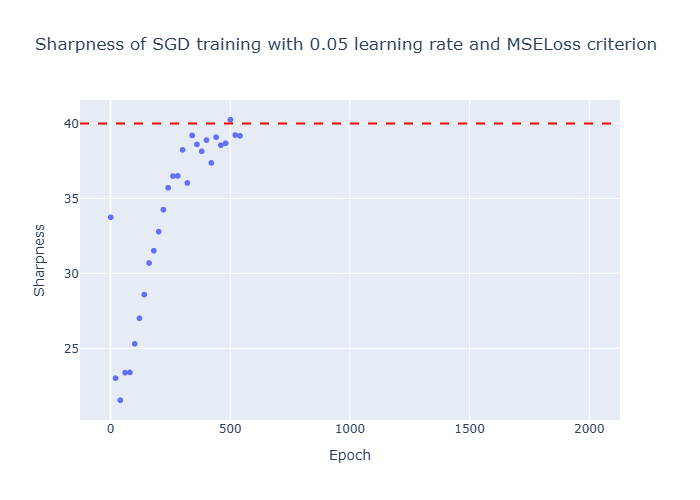

In [10]:
plot_sharpness(metadata=md, output=out, model_id=27)

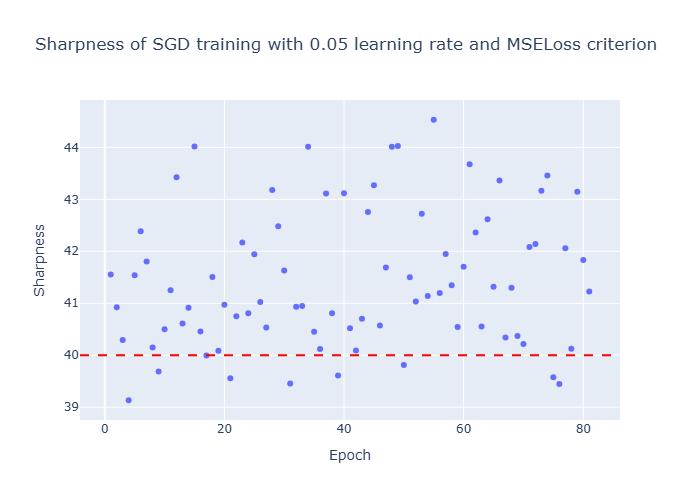

In [11]:
plot_sharpness(metadata=md, output=out, model_id=28)

In [12]:
def plot_accuracy(metadata, output, model_id, include_eos_threshold=True):
    # filter model_id
    metadata = metadata[metadata['model_id']==model_id]
    output = output[output['model_id']==model_id]

    # metametrics
    optimizer = metadata['optimizer'].iloc[0]
    learning_rate = metadata['learning_rate'].iloc[0]
    criterion = metadata['criterion'].iloc[0]

    # figure creation
    fig = px.scatter(output, x='epoch', y=['train_accuracy', 'test_accuracy'],
                     labels={
                         "epoch": "Epoch",
                         "train_accuracy": "Train Accuracy",
                         "test_accuracy": "Test Accuracy",
                         'value': 'Accuracy',
                     },
                     title=f"Accuracy of {optimizer} training with {learning_rate} learning rate and {criterion} criterion")

    return fig

In [27]:
plot_accuracy(metadata=md, output=out, model_id=28)

# Multi-Model Tests

In [14]:
# Using the training params as above (minus lr)
epochs = 2000
accuracy = 0.999

# custom lr list
learning_rate_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
for lr in learning_rate_list:
    # initialize model
    model = models.FullyConnectedNet(
        input_size=input_size,
        num_hidden_layers=num_hidden_layers,
        hidden_layer_size=hidden_layer_size,
        num_labels=10,
        activation=nn.Tanh
    )
    criterion = nn.MSELoss()
    
    # Use optimizer with lr
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0)
    
    # Train model
    fn.train_minibatch_gd_model(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        epochs=epochs,
        accuracy=accuracy,
        train_loader=train_loader,
        test_loader=test_loader,
        output_dir=output_dir
    )

Training FullyConnectedNet with SGD and learning rate 0.01 for 2000 epochs.
Epoch [100/2000], Loss: 0.0667, Avg Batch Sharpness: 27.57, Train Acc: 0.5924
Epoch [200/2000], Loss: 0.0536, Avg Batch Sharpness: 27.76, Train Acc: 0.7824
Epoch [300/2000], Loss: 0.0453, Avg Batch Sharpness: 27.85, Train Acc: 0.8638
Epoch [400/2000], Loss: 0.0387, Avg Batch Sharpness: 31.83, Train Acc: 0.9134
Epoch [500/2000], Loss: 0.0336, Avg Batch Sharpness: 34.49, Train Acc: 0.9394
Epoch [600/2000], Loss: 0.0295, Avg Batch Sharpness: 36.30, Train Acc: 0.9594
Epoch [700/2000], Loss: 0.0254, Avg Batch Sharpness: 36.08, Train Acc: 0.9734
Epoch [800/2000], Loss: 0.0225, Avg Batch Sharpness: 45.86, Train Acc: 0.9750
Epoch [900/2000], Loss: 0.0198, Avg Batch Sharpness: 46.86, Train Acc: 0.9882
Epoch [1000/2000], Loss: 0.0172, Avg Batch Sharpness: 49.23, Train Acc: 0.9900
Epoch [1100/2000], Loss: 0.0153, Avg Batch Sharpness: 52.72, Train Acc: 0.9942
Epoch [1200/2000], Loss: 0.0136, Avg Batch Sharpness: 52.59, Tra

In [17]:
md, out = fn.load_output_files(output_dir)

In [48]:
def plot_eos_analysis(metadata, output, model_ids, include_eos_threshold=True):
    # Create subplots: Row 1 = Loss, Row 2 = Sharpness
    fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.1,
        subplot_titles=("Training Loss (Log Scale)", "Batch Sharpness (Hessian λ_max)")
    )

    # Color palette for different models
    colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A']
    
    # Misc. graph limits
    max_epoch = metadata[metadata['model_id'].isin(model_ids)]['num_epochs'].max()
    y_limit = output[output['model_id'].isin(model_ids)]['sharpness_H'].max() * 1.1
    
    for i, m_id in enumerate(model_ids):
        # Filter data for this specific model
        m_meta = metadata[metadata['model_id'] == m_id].iloc[0]
        m_data = output[output['model_id'] == m_id]

        lr = m_meta['learning_rate']
        name = f"LR={lr}"
        color = colors[i % len(colors)]

        # 1. Plot Training Loss
        fig.add_trace(
            go.Scatter(x=m_data['epoch'], y=m_data['train_loss'],
                       name=name, mode='lines', line=dict(color=color),
                       legendgroup=name),
            row=1, col=1
        )

        # 2. Plot Batch Sharpness
        fig.add_trace(
            go.Scatter(x=m_data['epoch'], y=m_data['sharpness_H'],
                       name=name, mode='lines', line=dict(color=color),
                       legendgroup=name, showlegend=False),
            row=2, col=1
        )

        # 3. Add the EoS Threshold (2 / learning_rate)
        if include_eos_threshold:
            eos_val = 2.0 / lr
            fig.add_shape(
                type="line", line=dict(color=color, dash="dash", width=2),
                x0=0, x1=max_epoch,
                y0=eos_val, y1=eos_val,
                row=2, col=1
            )
            # Label for the threshold
            fig.add_annotation(
                x=max_epoch, y=eos_val,
                text=f"2/η ≈ {eos_val:.1f}", showarrow=False,
                yshift=10, row=2, col=1, font=dict(color=color)
            )

    # Update Layout
    fig.update_yaxes(type="log", title_text="Loss", row=1, col=1)
    fig.update_yaxes(title_text="λ_max (Batch Hessian)", range=[0, y_limit], row=2, col=1)
    fig.update_xaxes(title_text="Epoch", row=2, col=1)

    fig.update_layout(
        height=800,
        title_text="Edge of Stochastic Stability Analysis",
        template="plotly_white",
        hovermode="x unified"
    )

    return fig

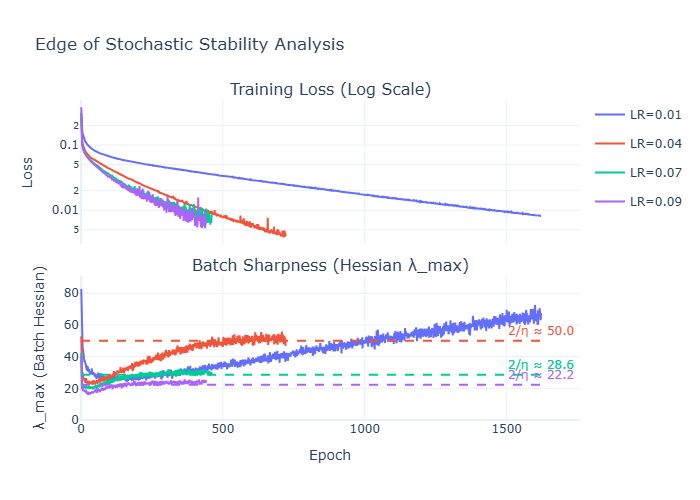

In [49]:
plot_eos_analysis(metadata=md, output=out, model_ids=[29, 32, 35, 37])

In [43]:
# Using the training params as above (minus lr)
epochs = 2000
accuracy = 0.999

# custom lr list
learning_rate_list = [0.01, 0.04, 0.07, 0.09]
for lr in learning_rate_list:
    # initialize model
    model = models.FullyConnectedNet(
        input_size=input_size,
        num_hidden_layers=num_hidden_layers,
        hidden_layer_size=hidden_layer_size,
        num_labels=10,
        activation=nn.Tanh
    )
    criterion = nn.MSELoss()

    # Use optimizer with lr
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0)

    # Train model (FULL HESSIAN)
    fn.train_sgd_model(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        epochs=epochs,
        accuracy=accuracy,
        train_loader=train_loader,
        test_loader=test_loader,
        X=X,
        y=y,
        output_dir=output_dir
    )

Training FullyConnectedNet with SGD and learning rate 0.01 for 2000 epochs.
Epoch [1000/2000], Loss: 0.0172, Time: 1.1, Train Acc: 0.9928, Test Acc: 0.2710
Completed training of FullyConnectedNet with SGD and learning rate 0.01. Took 1701 epoches and 109.44 seconds. Final training accuracy: 0.9990; Final testing accuracy: 0.2510
Saved with model_id 38
Training FullyConnectedNet with SGD and learning rate 0.04 for 2000 epochs.
Completed training of FullyConnectedNet with SGD and learning rate 0.04. Took 681 epoches and 41.92 seconds. Final training accuracy: 0.9994; Final testing accuracy: 0.2410
Saved with model_id 39
Training FullyConnectedNet with SGD and learning rate 0.07 for 2000 epochs.
Completed training of FullyConnectedNet with SGD and learning rate 0.07. Took 601 epoches and 37.48 seconds. Final training accuracy: 0.9994; Final testing accuracy: 0.2250
Saved with model_id 40
Training FullyConnectedNet with SGD and learning rate 0.09 for 2000 epochs.
Completed training of Full

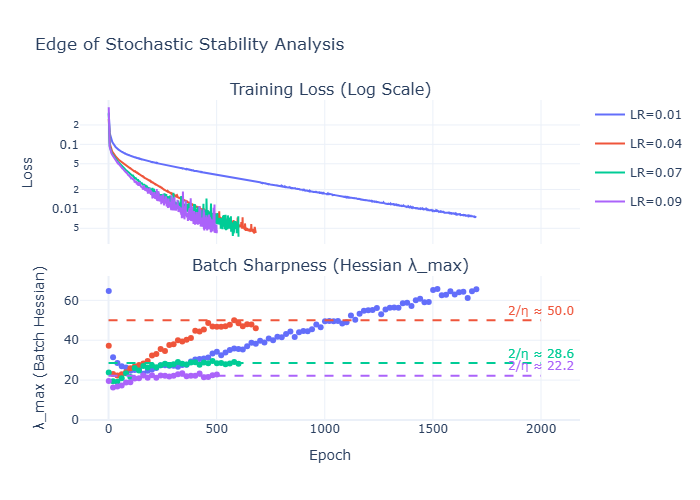

In [47]:
# Full Hessian
md, out = fn.load_output_files(output_dir)

plot_eos_analysis(metadata=md, output=out, model_ids=[38, 39, 40, 41])

## Batch size analysis

In [7]:
# Using the training params as above (minus lr)
epochs = 2000
accuracy = 0.999

# Varying Batch sizes
batch_size_list = [2, 16, 32, 64, 128, 256]
for bs in batch_size_list:
    # Set up dataloader
    train_dataset = TensorDataset(X, y)
    train_loader = DataLoader(
        train_dataset,
        batch_size=bs,
        shuffle=True,
        generator=seed.cpu_generator
    )
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # initialize model
    model = models.FullyConnectedNet(
        input_size=input_size,
        num_hidden_layers=num_hidden_layers,
        hidden_layer_size=hidden_layer_size,
        num_labels=10,
        activation=nn.Tanh
    )
    criterion = nn.MSELoss()

    # Use optimizer with lr=0.05 (2/40)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.0)

    # Train model (FULL HESSIAN)
    fn.train_sgd_model(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        epochs=epochs,
        accuracy=accuracy,
        train_loader=train_loader,
        test_loader=test_loader,
        X=X,
        y=y,
        output_dir=output_dir
    )

Training FullyConnectedNet with SGD and learning rate 0.05 for 2000 epochs.
Completed training of FullyConnectedNet with SGD and learning rate 0.05. Took 81 epoches and 193.97 seconds. Final training accuracy: 0.9996; Final testing accuracy: 0.2760
Saved with model_id 42
Training FullyConnectedNet with SGD and learning rate 0.05 for 2000 epochs.
Completed training of FullyConnectedNet with SGD and learning rate 0.05. Took 161 epoches and 49.21 seconds. Final training accuracy: 0.9992; Final testing accuracy: 0.2400
Saved with model_id 43
Training FullyConnectedNet with SGD and learning rate 0.05 for 2000 epochs.
Completed training of FullyConnectedNet with SGD and learning rate 0.05. Took 201 epoches and 35.37 seconds. Final training accuracy: 0.9990; Final testing accuracy: 0.2530
Saved with model_id 44
Training FullyConnectedNet with SGD and learning rate 0.05 for 2000 epochs.
Completed training of FullyConnectedNet with SGD and learning rate 0.05. Took 301 epoches and 29.77 seconds.

In [8]:
md, out = fn.load_output_files(output_dir)

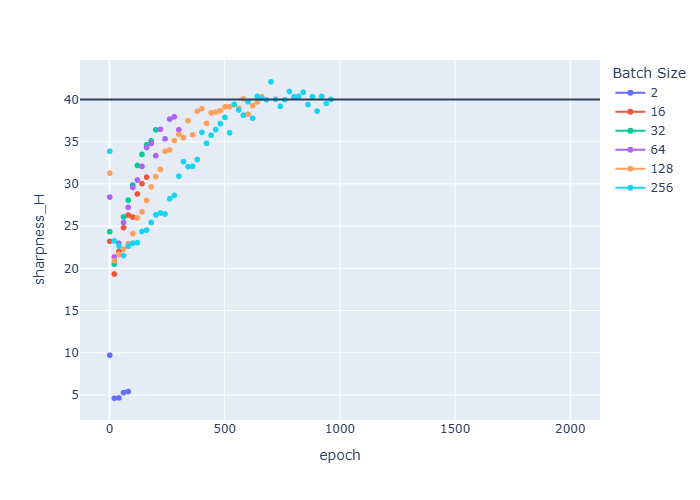

In [21]:
batch_map = {42: 2,
             43: 16,
             44: 32,
             45: 64,
             46: 128,
             47: 256}

out = out[out['model_id'].isin([42, 43, 44, 45, 46, 47])]
out['Batch Size'] = out['model_id'].map(batch_map)

fig = px.line(out, x='epoch', y='sharpness_H', color='Batch Size', markers=True)
fig.add_hline(40)
fig.show()

In [22]:
# Using the training params as above (minus lr)
epochs = 2000
accuracy = 0.999

# Varying Batch sizes
batch_size_list = [2, 16, 32, 64, 128, 256]
for bs in batch_size_list:
    # Set up dataloader
    train_dataset = TensorDataset(X, y)
    train_loader = DataLoader(
        train_dataset,
        batch_size=bs,
        shuffle=True,
        generator=seed.cpu_generator
    )
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # initialize model
    model = models.FullyConnectedNet(
        input_size=input_size,
        num_hidden_layers=num_hidden_layers,
        hidden_layer_size=hidden_layer_size,
        num_labels=10,
        activation=nn.Tanh
    )
    criterion = nn.MSELoss()

    # Use optimizer with lr=0.05 (2/40)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.0)

    # Train model
    fn.train_minibatch_gd_model(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        epochs=epochs,
        accuracy=accuracy,
        train_loader=train_loader,
        test_loader=test_loader,
        output_dir=output_dir
    )

Training FullyConnectedNet with SGD and learning rate 0.05 for 2000 epochs.
Completed. Saved with model_id 48
Training FullyConnectedNet with SGD and learning rate 0.05 for 2000 epochs.
Epoch [100/2000], Loss: 0.0064, Avg Batch Sharpness: 39.75, Train Acc: 0.9886
Completed. Saved with model_id 49
Training FullyConnectedNet with SGD and learning rate 0.05 for 2000 epochs.
Epoch [100/2000], Loss: 0.0137, Avg Batch Sharpness: 34.53, Train Acc: 0.9736
Epoch [200/2000], Loss: 0.0044, Avg Batch Sharpness: 42.50, Train Acc: 0.9984
Completed. Saved with model_id 50
Training FullyConnectedNet with SGD and learning rate 0.05 for 2000 epochs.
Epoch [100/2000], Loss: 0.0251, Avg Batch Sharpness: 28.30, Train Acc: 0.8594
Epoch [200/2000], Loss: 0.0106, Avg Batch Sharpness: 36.64, Train Acc: 0.9502
Epoch [300/2000], Loss: 0.0058, Avg Batch Sharpness: 43.87, Train Acc: 0.9986
Completed. Saved with model_id 51
Training FullyConnectedNet with SGD and learning rate 0.05 for 2000 epochs.
Epoch [100/2000]

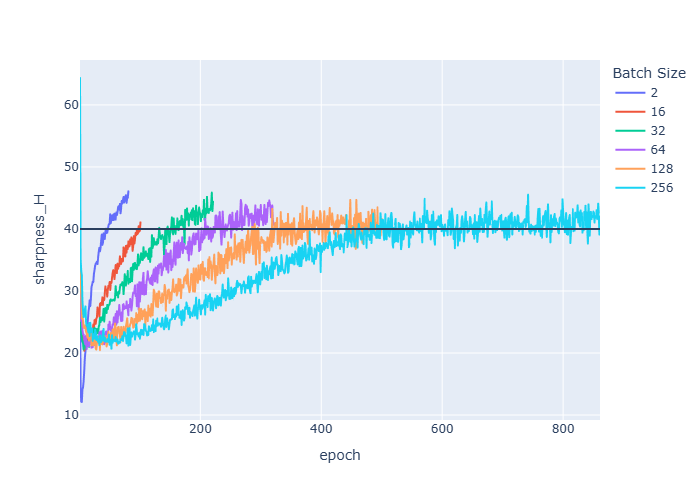

In [26]:
md, out = fn.load_output_files(output_dir)
batch_map = {48: 2,
             49: 16,
             50: 32,
             51: 64,
             52: 128,
             53: 256}

out = out[out['model_id'].isin([48, 49, 50, 51, 52, 53])]
out['Batch Size'] = out['model_id'].map(batch_map)

fig = px.line(out, x='epoch', y='sharpness_H', color='Batch Size')
fig.add_hline(40)
fig.show()